In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import imp
paNLS_path = '../paNLS'
paNLS = imp.load_package('paNLS', paNLS_path)

sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

%matplotlib inline

# paNLS Tutorial
Michelle L. Gill  
2015/08/09

paNLS is a Pandas-aware non-linear least squares (NLS) regression library.  Packages like Statsmodels and Patsy aren't well suited to the biological sciences where data fitting involves a variety of non-linear functions, such as exponential decays and other, irregular non-linear functions. paNLS is unique in that it will perform multiple regressions on a Pandas dataframe using specified columns of data in a manner analogous to Pandas `groupby` function. Returned parameters, error estimates, and models are all dataframes and contain the appropriate group identification columns.

paNLS utilizes an underlying library (also included) called NLS. This library performs the regression and calculates statistics on the individual groups. It can also be used alone for single regression operations. NLS uses Scipy's `leastsq` function for regression and contains two functions that I commonly use (exponential decay and a linear function), but it can handle custom functions as well.

Following are two demonstrations of paNLS and NLS using nuclear magnetic resonance (NMR) data that I acquired at four different magnetic field strengths (14.1, 16.5, 18.8, and 21.1 T) on a a protein called GCN4. There are data at each field strength for 54 amino acids, for a total of 216 regressions.

## 1. Determination of GCN4 transverse relaxation rates

This demonstration measures a parameter known as the transverse relaxation rate, $R_2$. The input data are peak intensities which exponentially decay with time. paNLS can perform all 216 regressions with a single command.

In [2]:
r2_data = pd.read_csv('GCN4_fourfield_R2.tsv', sep='\t')

# Number of residues, fields, and regressions
r2_data.resi.unique().shape[0], r2_data.field.unique().shape[0], r2_data[['resi','field']].drop_duplicates().shape[0]

(54, 4, 216)

The input data contain the residue number (`resi`), magnetic field strength (`field`), `time` in seconds (independent variable), and `intensity` in arbitrary units (dependent variable).

In [3]:
r2_data.head()

,resi,field,time,intensity
0,5,14.1,0.004,15615.701070
1,5,14.1,0.008,15647.389419
2,5,14.1,0.024,13730.034692
3,5,14.1,0.064,11014.702949
4,5,14.1,0.096,9902.334490


### Perform the regression and calculate a best fit line
The parameters of an exponential decay function will be fit to the data:  

$I_{(t)} = I_{(0)} \space e^{(-R_2 * t)}$  

where $I_{(0)}$ is the initial intensity, $I_{(t)}$ is the intensity at time $t$, and $R_2$ is the transverse relaxation rate. paNLS contains this equation.

The regression requires the data, a list of columns to group the data by (`resi` and `field`), the names of the dataframe columns containing the independent and dependent variables (`time` and `intensity`, respectively), and the name of the function (`exp`).

In [4]:
def exponential_decay(par, xdata):
    
    # Parse multiple input parameter
    # formats for intensity, rate    
    if hasattr(par,'valuesdict'):
        # lmfit parameter format
        var = par.valuesdict()
        inten = var['inten']
        rate = var['rate']
    elif hasattr(par,'keys'):
        # dict format
        inten = par['inten']
        rate = par['rate']
    else:
        # array/list/tuple format
        inten = par[0]
        rate = par[1]

    # Calculate the y-data from the parameters
    return inten * np.exp(-1*rate*xdata)

In [5]:
func = exponential_decay
groupcols = ['resi','field']
xname = 'time'
yname = 'intensity'

method = 'leastsq'
sigma = 0.95
threads = 4

In [6]:
params = [{'name':'inten', 'value':np.asarray(r2_data.groupby(groupcols)[yname].max()), 'vary':True},
          {'name':'rate', 'value':20.0, 'vary':True}]

r2_fit = paNLS.pdlmfit(r2_data, func, groupcols, 
                          params, xname, yname)

In [7]:
r2_fit.fit()
r2_fit.predict()

try loop


The returned object (`r2_fit`) contains parameters and statistics from the regression.

Many statistics about the regression are also returned, including the covariance matrix.

In [8]:
r2_fit.stats.head(n=4)

nobs  npar  dof         chisq      redchisq         aic  \
resi field                                                            
5    14.1     22     2   20  5.918743e+12  2.959371e+11  585.095084   
     16.5     20     2   18  2.361933e+14  1.312185e+13  608.106001   
     18.8     22     2   20  1.438859e+16  7.194297e+14  756.608557   
     21.1     16     2   14  1.142726e+16  8.162328e+14  553.371531   

                   bic           rss  \
resi field                             
5    14.1   587.277169  9.860060e+06   
     16.5   610.097466  5.118952e+07   
     18.8   758.790642  3.881116e+08   
     21.1   554.916708  3.106147e+08   

                                                        covar  
resi field                                                     
5    14.1   [[19453.4420609, 12.6357822049], [12.635782204...  
     16.5   [[131534.524367, 27.1367171464], [27.136717146...  
     18.8   [[884676.124346, 45.5837120289], [45.583712028...  
     21.1   [[2039800.09312, 30.5173738939], [30.517373893...

paNLS will also calculate a best fit curve. The number of points to predict can be set using `xnum` or will default to 50.

In [10]:
r2_fit.predict(xnum=20)
r2_fit.model.head()

xcalc         ycalc
resi field                        
5    14.1   0.004000  15004.983475
     14.1   0.014737  14207.577900
     14.1   0.025474  13452.548623
     14.1   0.036211  12737.643653
     14.1   0.046947  12060.730674

The rate, $R_2$, is the only parameter of interest, so to make plotting easier, intensities will be normalized to the initial intensity, as determined by regression. The dataframe `r2_fit.data` contains the original data which will be normalized and the model is in `r2_fit.model`.

In [11]:
r2_fit.model['ycalc'] = r2_fit.model.ycalc / r2_fit.results.inten
r2_fit.data['ydata'] = r2_fit.data.ydata / r2_fit.results.inten
r2_fit.data['ycalc'] = r2_fit.data.ycalc / r2_fit.results.inten

Plot the data and the best fit curve. Select just the last 24 residues and two magnetic fields (14.1, 21.1) for plotting so the plots aren't so difficult to read.

In [22]:
resi_sele = r2_fit.data.resi.unique()[-24:]
data_sele = np.in1d(r2_fit.data.field, [14.1, 21.1]) & np.in1d(r2_fit.data.resi, resi_sele)
model_sele = np.in1d(r2_fit.model.field, [14.1, 21.1]) & np.in1d(r2_fit.model.resi, resi_sele)
plot_data = r2_fit.data[data_sele].append(r2_fit.model[model_sele])

AttributeError: 'DataFrame' object has no attribute 'resi'

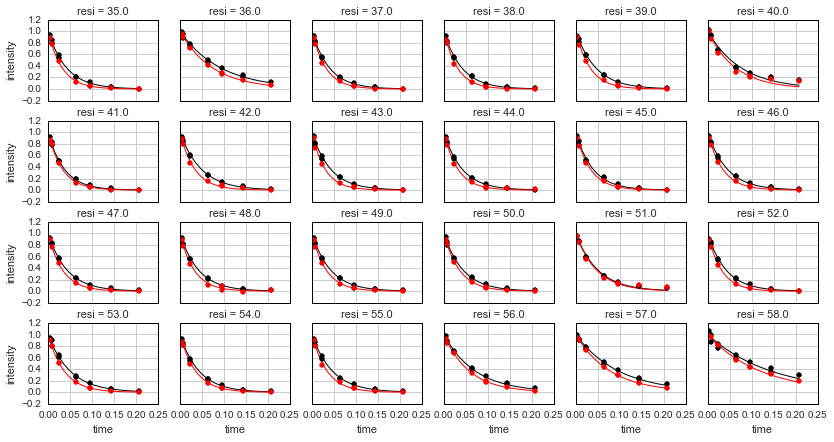

In [11]:
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})
sns.set_style("whitegrid",{'axes.edgecolor':'black'})

palette = {14.1:'black', 21.1:'red'}

grid = sns.FacetGrid(plot_data, col='resi', hue='field', palette=palette,
                     col_wrap=6, size=2.0, aspect=0.75, sharey=True, despine=False)

grid.map(plt.plot, 'xcalc', 'ycalc', marker='', ms=5, ls='-')
grid.map(plt.plot, 'time', 'intensity', marker='o', ms=5, ls='')

f = plt.gcf()
f.set_size_inches(12,6)
f.subplots_adjust(wspace=0.2, hspace=0.25)

## 2. Determination of the $J(\omega_N)$ spectral density term for GCN4

This demonstration uses NLS to determine if a parameter known as a spectral density function, $J(\omega_N)$, varies linearly with the inverse of the square of the $^{15}N$ frequency ($\omega_N^{-2}$), which is calculated from each of the four magnetic fields. The independent variable is $\omega_N^{-2}$, which is labeled `wN_2` in the file, the dependent variable, $J(\omega_N)$, is labeled `JwN`, and error estimates for $J(\omega_N)$ are labeled `JwN_err`.

A single residue (48) will be selected from the data since NLS operates on one group of data at a time. This analysis involves fitting data from all four magnetic fields at once, so there is no field to select.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from paNLS import paNLS
from paNLS.nls import NLS

In [13]:
JwN_data = pd.read_csv('demo_data/GCN4_fourfield_JwN.tsv', sep='\t')

resi = 48
JwN_data = JwN_data.ix[JwN_data.resi == resi]

The input for NLS is similar to paNLS except that all the inputs are arrays themselves, rather than column names of a dataframe. The function `lin` is a linear equation, and the parameter `p0` tells NLS to fit two parameters (`slope` and `intercept`) rather than just `slope`.

In [14]:
JwN_fit = NLS(JwN_data.wN_2, JwN_data.JwN, yerr=JwN_data.JwN_err,
              func='lin', p0=2)

In [15]:
JwN_fit.summary()


Non-linear Least Squares
Model: linear
Parameters:
                      Estimate    Std. Error      t-value   P(>|t|)     Lower     Upper
slope     		0.0172        0.0008      22.4431    0.0020    0.0139    0.0206
intercept 		0.0089        0.0029       3.0620    0.0922    0.0139    0.0214

Residual Standard Error:  0.1955
Degress of Freedom: 2


The resulting parameter names, values, and standard errors:

In [16]:
JwN_fit.parmNames, JwN_fit.parmVals, JwN_fit.parmSE

(['slope', 'intercept'],
 array([ 0.01724546,  0.0089076 ]),
 array([ 0.00076841,  0.00290906]))

Model calculation with NLS occurs automatically, but a different array of desired dependent values can also be entered.

In [17]:
JwN_fit.ycalc

array([ 0.12683994,  0.06131446,  0.09555725,  0.07523515])

In [18]:
xcalc = np.array([JwN_data.wN_2.min(), JwN_data.wN_2.max()])
ycalc = JwN_fit.predict(xcalc)
xcalc, ycalc

(array([ 3.03887908,  6.83845779]), array([ 0.06131446,  0.12683994]))

Much like paNLS, the outputs of NLS are designed to be easy to visualize.

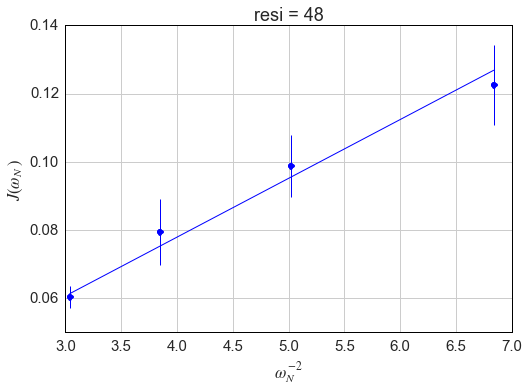

In [19]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.0})
sns.set_style("whitegrid",{'axes.edgecolor':'black'})

plt.plot(xcalc, ycalc, ls='-', ms='', color='blue')
plt.errorbar(JwN_data.wN_2, JwN_data.JwN, yerr=JwN_data.JwN_err, 
             ls='', marker='o', color='blue')
ax = plt.gca()
ax.set_xlabel('$\omega_N^{-2}$')
ax.set_ylabel('$J(\omega_N)$')
ax.set_title('resi = %d' % resi)